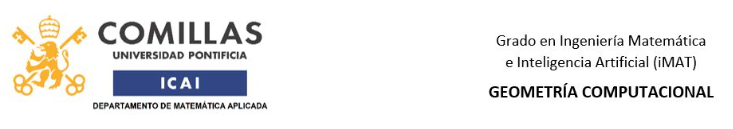

  # Proyecto final: Algoritmo QuickHull
  ## Curso 2025-2026
  ### Rafael Onieva Beamonte, Iñaki Juan-Aracil Cadarso, Jaime Sainz Meseguer
  


In [1]:
load("BibliotecaProyecto.py")

In [20]:
# Auxiliar recursiva: S = puntos a la DERECHA de la recta dirigida ab
def clasifica_puntos(P, historial, pasos_iteracion):
    descartados = []         
    if pasos_iteracion > 0:
        for paso_hist in historial[:pasos_iteracion]:
            a_h = paso_hist['a']
            b_h = paso_hist['b']
            c_h = paso_hist['p']
            if c_h is None:
                continue
            tri = [a_h, c_h, b_h]
            for p in P:
                if p in descartados or p in tri:
                    continue
                if enTriangulo(p, tri):
                    descartados.append(p)

    puntos_dentro = descartados
    puntos_fuera  = [p for p in P if p not in descartados]
    return puntos_dentro, puntos_fuera

def Quickhull(a, b, S, historial):
    
    #Primero guardamos la iteración
    iteracion = {'a': a, 'b': b, 'S': list(S), 'p': None}
    historial.append(iteracion)
    
    #Función en sí: 
    if len(S) == 0:
        return []

    #Primero calculamos el punto más lejano a la recta ab (Punto c)
    c = S[0]
    dmax = abs(areaSignada(a, b, c))
    for p in S:
        d = abs(areaSignada(a, b, p))
        if d > dmax:
            dmax = d
            c = p
    
    #Guardamos el pivote de este paso
    iteracion["p"] = c
    
    
    #Eliminamos los puntos interiores al triángulo a-c-b
    #y construimos las cadenas A (derecha de ac) y B (derecha de cb)
    A = []
    B = []
    for p in S:
        
        if enTriangulo(p, [a, c, b]):
            continue                    #quitamos los puntos interiores o en el borde del triángulo acb

        if areaSignada(a, c, p) < 0:    #derecha de ac
            A.append(p)
        elif areaSignada(c, b, p) < 0:  #derecha de cb
            B.append(p)

    #Recursión: cadena de a->b por este lado
    return Quickhull(a, c, A, historial) + [c] + Quickhull(c, b, B, historial)


def QuickHull(P):
    #Casos triviales
    
    historial = []
    
    if len(P) < 3:
        print("Se necesitan al menos 3 puntos para calcular el cierre convexo.")
        return P

    #Extremos en x
    a = Xmin(P)
    b = Xmax(P)

    #Partición inicial:
    # Sab: puntos a la DERECHA de ab
    # Sba: puntos a la DERECHA de ba (equiv. izquierda de ab)
    Sab = []
    Sba = []
    for p in P:
        if p == a or p == b:
            continue
        s = areaSignada(a, b, p)
        if s < 0:          # derecha de ab
            Sab.append(p)
        elif s > 0:        # derecha de ba
            Sba.append(p)

    # Cadenas de la envolvente
    H1 = Quickhull(a, b, Sab, historial)   # de a a b por un lado
    H2 = Quickhull(b, a, Sba, historial)   # de b a a por el otro

    # Envolvente completa en sentido antihorario
    H = [a] + H1 + [b] + H2
    return H, historial


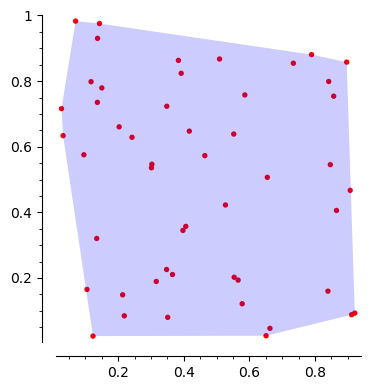

In [21]:
P = [[random(), random()] for i in range(50)]
H, historial = QuickHull(P)
point(P, size=15, color="red") + polygon(H, alpha=0.2) 



In [22]:
@interact
def applet_quickhull(
    modo_puntos = selector(['Aleatoriamente', 'Manualmente'],
                           label='Cómo generar los puntos:'),
    n            = slider(3, 300, 1, 50,
                          label='Número de puntos (si son aleatorios)'),
    puntos_manuales = input_box([[0,0],[1,0],[1,1],[0,1]],
                                label='Lista de puntos (si es manual)'),
    
    semilla =  input_box(0, label='Semilla (para fijar la nube aleatoria)'), 
    iteracion = slider(0, 50, 1, 0,
                  label='Iteración i del algoritmo')
):
    
    #Construcción de la nube de puntos:
    
    #De manera aleatoria
    if modo_puntos == 'Aleatoriamente':
        set_random_seed(Integer(semilla))
        P = [[random(), random()] for _ in range(n)]  
    
    #De manera manual
    else:
        P = puntos_manuales


    #Llamamada a la función principal QuickHull
    H, historial = QuickHull(P)

    #Iteraciones totales
    num_pasos = len(historial)
    pasos_iteracion = min(iteracion, num_pasos)
    #Calculamos que  puntos ya estan "dentro" de la envolvente actual
    descartados = []
    puntos_dentro, puntos_fuera = clasifica_puntos(P, historial, pasos_iteracion)

    #calculamos la envolvente parcial hasta el paso actual
    envolvente_parcial = []
    if num_pasos > 0 and 0 < pasos_iteracion < num_pasos:
        vistos = []

        for paso_hist in historial[:pasos_iteracion]:
            c_h = paso_hist['p']
            if c_h is not None and c_h not in vistos:
                vistos.append(c_h)

        a_inicial = Xmin(P)
        b_inicial = Xmax(P)
        if a_inicial not in vistos:
            vistos.insert(0, a_inicial)
        if b_inicial not in vistos:
            vistos.append(b_inicial)
        for p in H:
            if p in vistos:
                envolvente_parcial.append(p)
    #Dibujamos          
    g = Graphics()
    if puntos_fuera:
        g += point(puntos_fuera, size=15, color='red')
    if puntos_dentro:
        g += point(puntos_dentro, size=15, color='gray')
        
    #dibujar la envolvente entera
    if pasos_iteracion == 0 or pasos_iteracion == num_pasos or num_pasos == 0:
        if len(H) >= 3:
            g += polygon(H, alpha=0.2)
        if len(H) >= 2:
            g += line(H + [H[0]]) 
            
    else: #dibujar la parcial
        if len(envolvente_parcial) >= 3:
            g += polygon(envolvente_parcial, alpha=0.2)
            g += line(envolvente_parcial + [envolvente_parcial[0]])
        elif len(envolvente_parcial) == 2:
            g += line(envolvente_parcial)

    #Dibujo superpuesto del paso i: 
    if 0 < pasos_iteracion < num_pasos:
        paso = historial[pasos_iteracion - 1]   
        a = paso['a']
        b = paso['b']
        S = [p for p in paso['S'] if p not in puntos_dentro]
        c = paso['p']
        
        if c is not None:
            tri_actual = [a, c, b]
            g += polygon(tri_actual, alpha=0.10, color='yellow')
        g += line([a, b], color='blue', thickness=3, linestyle='--')

        if S:
            g += point(S, size=20, color='green')

        if c is not None:
            g += point(c, size=40, color='orange')
            g += circle(c, 0.02, color='orange', thickness=3)
        g += point([a], size=30, color='blue')
        g += point([b], size=30, color='blue')
    show(g, aspect_ratio=1, figsize=(8,8))


    print("Número total de puntos:", len(P))
    print("Número de vértices de la envolvente convexa:", len(H))


Interactive function <function applet_quickhull at 0x6fc6afc91e0> with 5 widgets
  modo_puntos: Dropdown(descr…